# 2022-08-31 Fourier and conditioning

## Last time

* Solutions and matrix properties
* Arbitrary order discretization
* Method of manufactured solutions

## Today
* Techniques for boundary conditions
* Fourier analysis of stencils
* Conditioning of Vandermonde matrices

## Reading to discuss today

[Journal of Fluids Engineering: Editorial Policy Statement on the Control of Numerical Accuracy (1986)](https://jedbrown.org/files/RoacheGhiaWhite-JFEEditorialPolicyStatementControlOfNumericalAccuracy-1986.pdf)

## Talks in ECOT 831 after class (12:15)

* Igor Baratta (Cambridge): Toward performance-portable matrix-free solvers in FEniCSx
* Joseph Dean (Cambridge): Hybridised discontinuous Galerkin methods in FEniCSx

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

fdstencil (generic function with 1 method)

# Interpolation by Vandermonde matrices

We can compute a polynomial

$$ p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb $$

that assumes function values $p(x_i) = u_i$ by solving a linear system with the Vandermonde matrix.

$$ \underbrace{\begin{bmatrix} 1 & x_0 & x_0^2 & \dotsb \\
    1 & x_1 & x_1^2 & \dotsb \\
    1 & x_2 & x_2^2 & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_V \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} = \begin{bmatrix} u_0 \\ u_1 \\ u_2 \\ \vdots \end{bmatrix} .$$

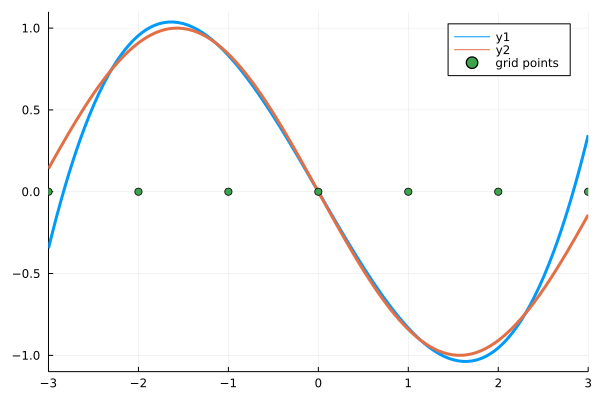

In [43]:
x = LinRange(-3, 3, 7)
u = sin.(x)
plot([z -> fdstencil(x, z, 2) * u,
        z -> -sin(z)], xlim=(-3, 3)) 
scatter!(x, 0*x, label="grid points")

# Convergence order

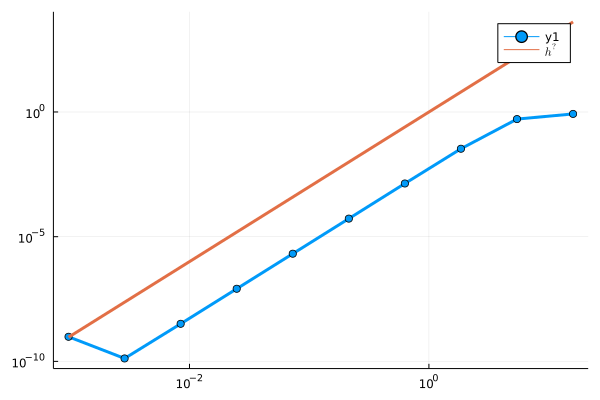

In [6]:
hs = 2 .^ -LinRange(-4, 10, 10)
function diff_error(u, du, h; n, k, z=0)
    x = LinRange(-h, h, n) .+ .5
    fdstencil(x, z, k) * u.(x) - du.(z)
end
errors = [diff_error(sin, t -> -sin(t), h, n=5, k=2, z=.5+0.1*h)
    for h in hs]
plot(hs, abs.(errors), marker=:circle)
plot!(h -> h^3, label="\$h^?\$", xscale=:log10, yscale=:log10)

## Observations

* When using $n=3$ points, we fit a polynomial of degree 2 and have error $O(h^3)$ for interpolation $p(0)$.
* Each derivative gives up one order of accuracy in general.
* Centered diff on uniform grids can have extra cancellation (superconvergence)
* The Vandermonde matrix is notoriously ill-conditioned with many points $n$. We recommend using a [stable algorithm from Fornberg](https://doi.org/10.1137/S0036144596322507).

# High order discretization of the Laplacian
## The Poisson problem $-u_{xx} = f$ with boundary conditions

In [44]:
function poisson(x, spoints, forcing; left=(0, zero), right=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2)
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1])
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1])
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

poisson (generic function with 1 method)

In [46]:
L, b = poisson(LinRange(-1, 1, 6), 5, zero, left=(1, zero))
L

6×6 Matrix{Float64}:
 -5.20833   10.0       -7.5       3.33333  -0.625      0.0
 -5.72917   10.4167    -3.125    -2.08333   0.520833   0.0
  0.520833  -8.33333   15.625    -8.33333   0.520833   0.0
  0.0        0.520833  -8.33333  15.625    -8.33333    0.520833
  0.0        0.520833  -2.08333  -3.125    10.4167    -5.72917
  0.0        0.0       -0.0       0.0      -0.0        1.0

# Method of manufactured solutions

## Problem: analytic solutions to PDEs are hard to find

Let's choose a smooth function with rich derivatives,
$$ u(x) = \tanh(x) . $$
Then $$ u'(x) = \cosh^{-2}(x) $$ and $$ u''(x) = -2 \tanh(x) \cosh^{-2}(x) . $$

* This works for nonlinear too.

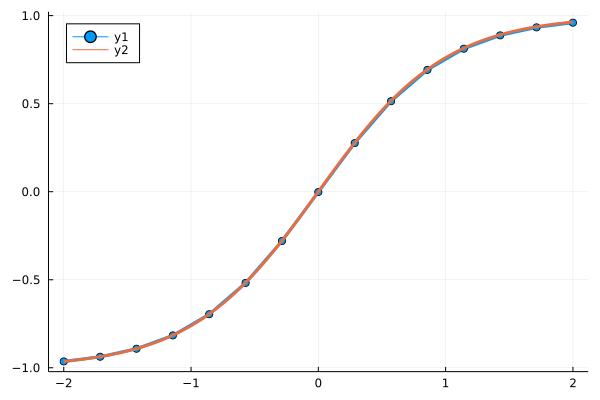

In [56]:
x = LinRange(-2, 2, 15)
L, rhs = poisson(x, 5,
    x -> 2 * tanh(x) / cosh(x)^2,
    left=(0, tanh), 
    right=(1, x -> cosh(x)^-2))
u = L \ rhs
plot(x, u, marker=:circle, legend=:topleft)
plot!(tanh)

# Convergence rate

In [60]:
ns = 2 .^ (3:10)
hs = 1 ./ ns
function poisson_error(n; spoints=3)
    x = LinRange(-2, 2, n)
    L, rhs = poisson(x, spoints, x -> 2 * tanh(x) / cosh(x)^2,
        left = (0, tanh),
        right = (1, x -> cosh(x)^-2))
    u = L \ rhs
    norm(u - tanh.(x), Inf)
end

poisson_error (generic function with 1 method)

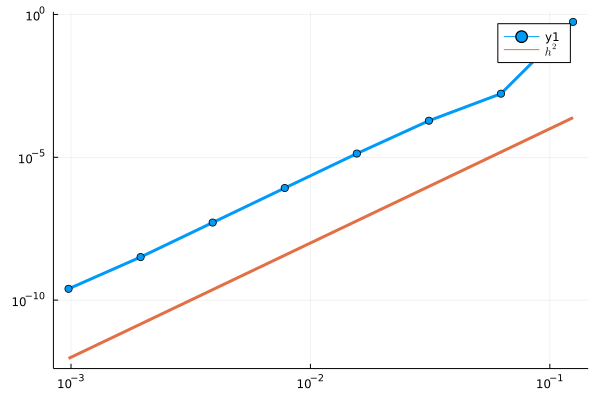

In [67]:
plot(hs, [poisson_error(n, spoints=5) for n in ns], marker=:circle)
plot!(h -> h^4, label="\$h^2\$", xscale=:log10, yscale=:log10)

# Symmetry in boundary conditions: Dirichlet

We have implemented Dirichlet conditions by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{1:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_0 \\ \\ u_{1:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{1:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.
* We can eliminate $u_0$ and create a reduced system for $u_{1:}$.
* Generalize: consider a $2\times 2$ block system
$$ \begin{bmatrix} I & 0 \\ A_{10} & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 \end{bmatrix} .$$

We can rearrange as
$$ A_{11} u_1 = f_1 - A_{10} f_0, $$
which is symmetric if $A_{11}$ is.
* This is called "lifting" and is often done implicitly in the mathematics literature.  It is convenient for linear solvers and eigenvalue solvers, but inconvenient for IO and postprocessing, as well as some nonlinear problems.
* Convenient alternative: write
$$ \begin{bmatrix} I & 0 \\ 0 & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 - A_{10} f_0 \end{bmatrix}, $$
which is symmetric and decouples the degrees of freedom associated with the boundary. This method applies cleanly to nonlinear problems.
* Optionally scale the identity by some scalar related to the norm of $A_{11}$.

# Symmetry in boundary conditions: Neumann

Consider FD discretization of the Neumann boundary condition
$$ \frac{du}{dx}(1) = b . $$
1. Use a one-sided difference formula as in
$$ \frac{u_n - u_{n-1}}{h} = b . $$
  * an extra discretization choice
  * may reduce order of accuracy compared to interior discretization, lose symmetry.
2. Temporarily introduce a ghost value $u_{n+1} = u(x_{n+1} = 1 + h)$ (possibly more) and define it to be a reflection of the values from inside the domain.  In the case $b=0$, this reflection is $u_{n+i} = u_{n-i}$.  More generally,
$$ u_{n+i} = u_{n-i} + 2b(x_n - x_{n-i}) . $$

After this definition of ghost values, we apply the interior discretization at the boundary. For our reference equation, we would write

$$ \frac{-u_{n-1} + 2 u_n - u_{n+1}}{h^2} = f(x_n) $$

which simplifies to $$ \frac{u_n - u_{n-1}}{h^2} = f(x_n)/2 + b/h $$
after dividing by 2 and moving the boundary term to the right hand side.

# Fourier analysis of stencils

Consider the plane waves $\phi(x, \theta) = e^{i\theta x}$.

Sample $\phi$ on a discrete grid $x = \mathbb Z$ and apply the stencil
\begin{align}
S \phi(x, \theta) &= s_{-1} \phi(x-1, \theta) + s_{0} \phi(x, \theta) + s_1 \phi(x+1,\theta) \\
&= \Big( s_{-1} e^{-i\theta} + s_0 + s_{1} e^{i\theta} \Big) \phi(x, \theta)
\end{align}
With $S = \begin{bmatrix} -1 & 2 & -1 \end{bmatrix}$, we get
$$S \phi(x, \theta) = \underbrace{(2 - 2 \cos\theta)}_{\hat S(\theta)} \phi(x, \theta)$$
We call $\hat S(\theta)$ the *symbol* of the operator.
What is the symbol of the continuous second derivative?

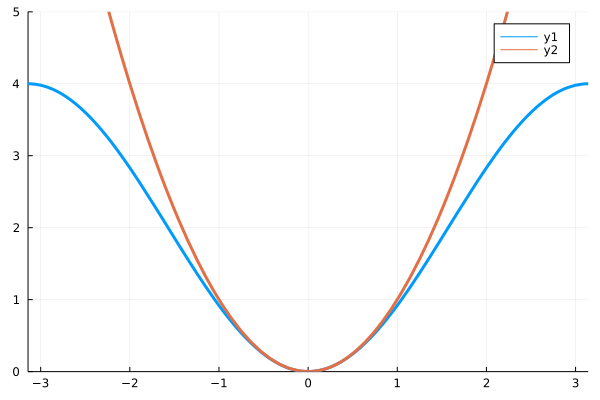

In [12]:
plot([theta -> 2 - 2*cos(theta),
        theta -> theta^2],
    xlims=(-pi, pi), ylim=(0, 5))

# Numerically computing symbols

In [70]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

theta = LinRange(-pi, pi, 10)
symbol([-.5 0 .5], theta)
#symbol([1 -2 1], theta)

10-element Vector{ComplexF64}:
 0.0 - 1.2246467991473532e-16im
 0.0 - 0.6427876096865395im
 0.0 - 0.9848077530122081im
 0.0 - 0.8660254037844388im
 0.0 - 0.34202014332566877im
 0.0 + 0.34202014332566877im
 0.0 + 0.8660254037844385im
 0.0 + 0.9848077530122081im
 0.0 + 0.6427876096865395im
 0.0 + 1.2246467991473532e-16im

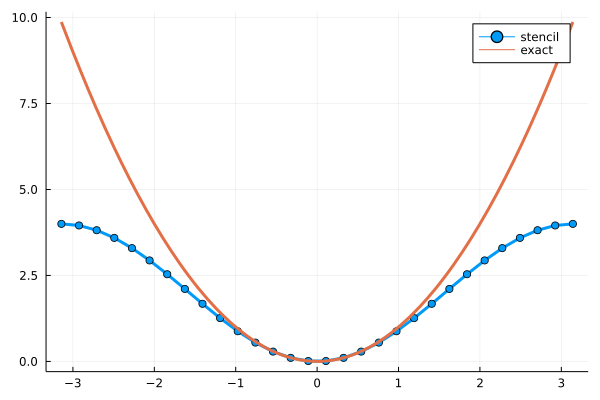

In [72]:
function plot_symbol(S, deriv, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    plot!(fig, th -> th^deriv, label="exact")
    fig
end

#plot_symbol([-.5 0 .5], 1)
plot_symbol([1 -2 1], 2)

# Stencils of high-order operators

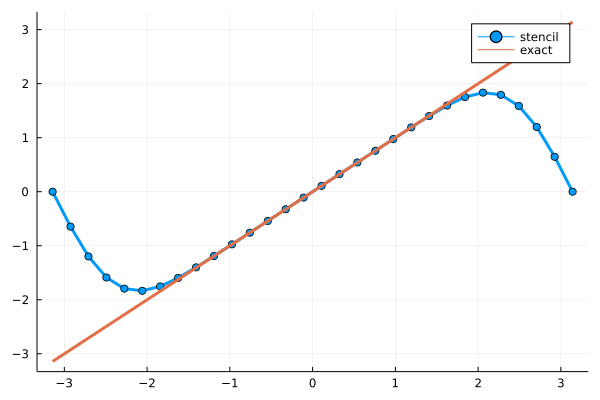

In [22]:
x = -5:5
plot_symbol(fdstencil(x, 0, 1), 1)

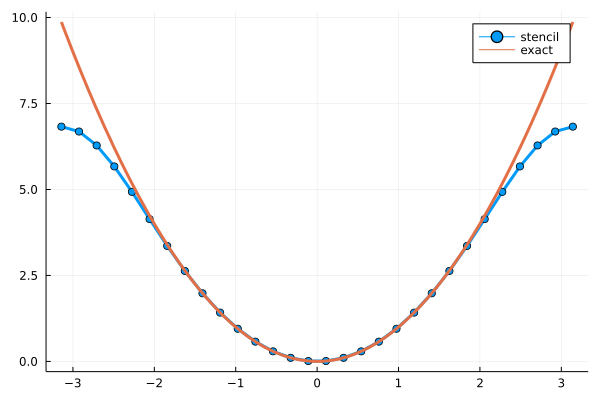

In [23]:
x = -5:5
plot_symbol(fdstencil(x, 0, 2), 2)

# Outlook on Fourier methods

* the Fourier modes $e^{i\theta x}$ and their multi-dimensional extensions are eigenvectors of **all** stencil-type operations
* "high frequencies" $[-\pi, \pi) \setminus [-\pi/2, \pi/2)$ are generally poorly resolved so we need to use a grid fine enough that important features are at low frequencies $[-\pi/2, \pi/2)$
* same technique can be used to study the inverse (and approximations thereof), as with multigrid and multilevel domain decomposition methods (later in the course)
* these methods can also be framed within the theory of (block) Toeplitz matrices

# Visualizing matrix transformations

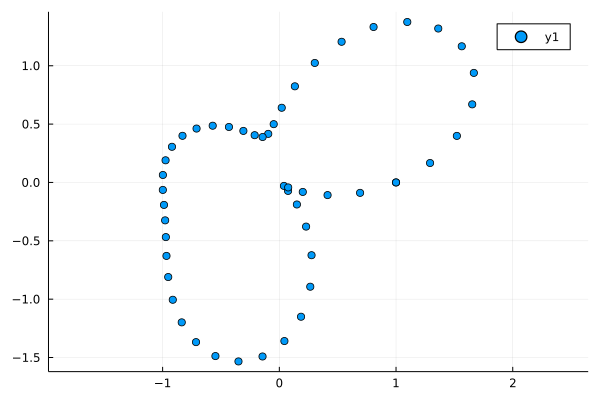

In [24]:
function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    x = r .* cos.(theta)
    y = r .* sin.(theta)
    x, y
end
x, y = peanut()
scatter(x, y, aspect_ratio=:equal)

Group these points into a $2\times n$ matrix $X$. Note that multiplication by any matrix $A$ is applied to each column separately, i.e.,

$$ A \underbrace{\Bigg[ \mathbf x_1 \Bigg| \mathbf x_2 \Bigg| \dotsb \Bigg]}_X = \Bigg[ A \mathbf x_1 \Bigg| A \mathbf x_2 \Bigg| \dotsb \Bigg] $$

In [25]:
X = [x y]'
size(X)

(2, 50)

# Visualizing the Singular Value Decomposition

2-element Vector{Float64}:
 3.5271281361990567
 0.7079334345925704

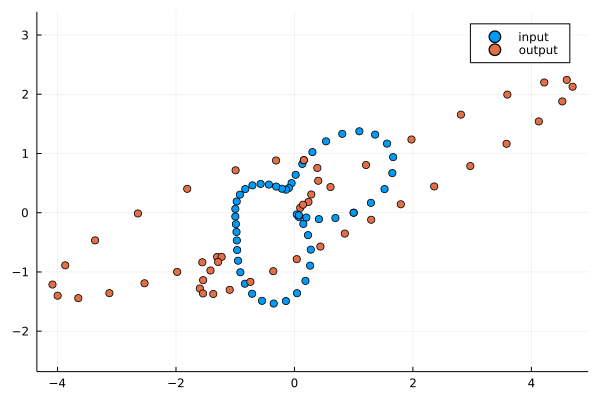

In [26]:
function tplot(A)
    x, y = peanut()
    X = [x y]'
    Y = A * X
    scatter(X[1,:], X[2,:], label="input", aspect_ratio=:equal)
    scatter!(Y[1,:], Y[2,:], label="output")
end

A = randn(2, 2)
display(svdvals(A))
tplot(A)

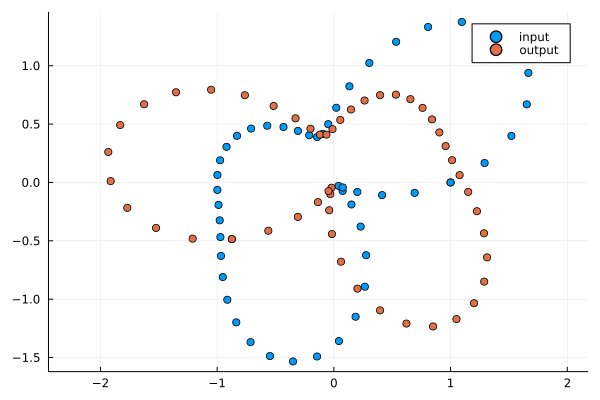

In [27]:
U, S, V = svd(A)
tplot(U)

# Condition number of interpolation

In [30]:
n = 20
source = LinRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
svdvals(A)

20-element Vector{Float64}:
 4141.821782616643
  756.1886116478436
   11.201394442903565
    5.2003668113747805
    2.326389915733187
    2.28865315753632
    2.2826626548042968
    2.282658231256019
    2.282657730773852
    2.2826577307583236
    2.2826577297323856
    2.2826577141906412
    2.2825938632428557
    2.282352200333904
    2.2484549739833892
    2.2449230244092657
    1.9014541632841195
    1.7794033224148031
    1.0093167855491605
    1.0064482710718898

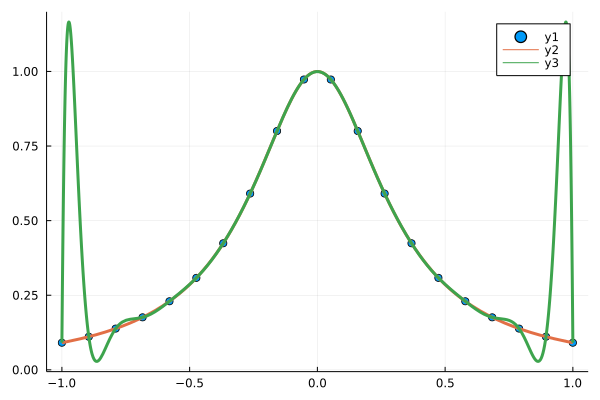

In [31]:
runge(x) = 1 / (1 + 10*x^2)
y = runge.(source)
scatter(source, y)
plot!([runge,
        x -> (vander([x], n) / P * y)[1]])
# plot!(target, A * y)

# The bad singular vectors

$$ A = U \Sigma V^T $$


In [32]:
n = 11
source = LinRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
U, S, V = svd(A)
S

11-element Vector{Float64}:
 34.77706851205524
 11.13125653860779
  3.200622823579756
  3.1551891145187843
  3.1464270560667247
  3.146390542844354
  3.1459494752514874
  2.900733962570026
  2.700731526422623
  1.2170432449283064
  1.1628054393968887

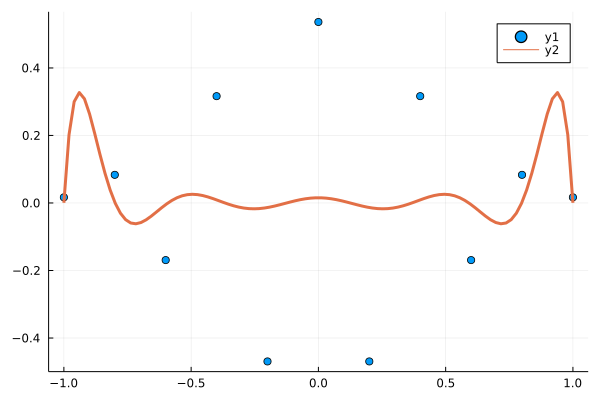

In [33]:
scatter(source, V[:,1])
plot!(target, U[:,1])

# Choosing the source points

In [34]:
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

CosRange (generic function with 1 method)

In [35]:
n = 15
source = CosRange(-1, 1, n)
target = LinRange(-1, 1, 100)
P = vander(source)
A = vander(target, n) / P
svdvals(A)

15-element Vector{Float64}:
 3.322445257960405
 3.295148962438826
 3.239022400818026
 3.1811090404013336
 3.0703313983108265
 2.9872800167943647
 2.812157783053922
 2.705974980411089
 2.4581412991002862
 2.320177305779112
 2.017320105389942
 1.7903748104690793
 1.5900555135944288
 1.0373676954023048
 1.031069620176098

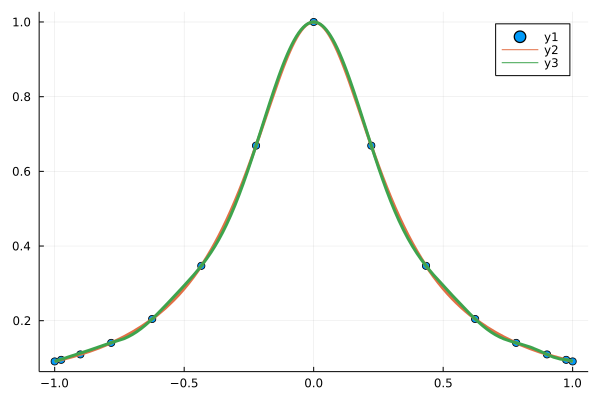

In [36]:
runge(x) = 1 / (1 + 10*x^2)
y = runge.(source)
scatter(source, y)
plot!([runge,
        x -> (vander([x], n) / P * y)[1]])

# Condition number of interpolation on `CosRange` points

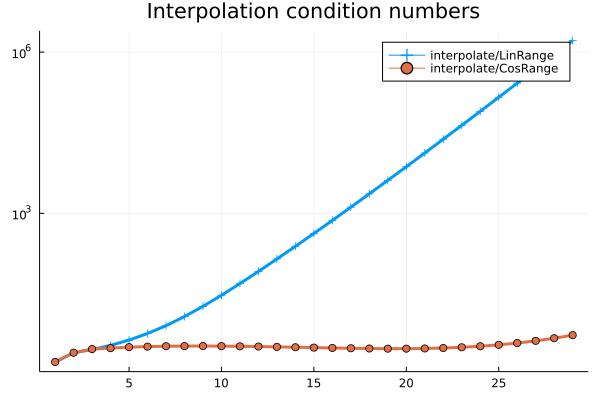

In [37]:
interpolate(source, target=LinRange(-1, 1, 100)) = vander(target, length(source)) / vander(source)

plot_cond(mat, points) = plot!([
        cond(mat(points(-1, 1, n)))
        for n in 2:30], label="$mat/$points", marker=:auto, yscale=:log10)

plot(title="Interpolation condition numbers")
plot_cond(interpolate, LinRange)
plot_cond(interpolate, CosRange)

# Vandermonde conditioning, stable algorithms

It is possible for interpolation to be well-conditioned, but construct it from ill-conditioned pieces.

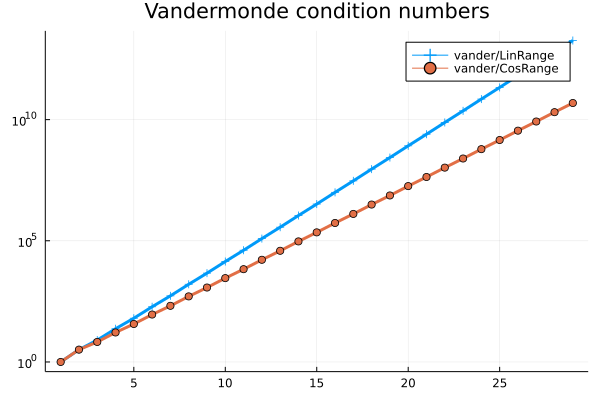

In [38]:
plot(title="Vandermonde condition numbers")
plot_cond(vander, LinRange)
plot_cond(vander, CosRange)

# Chebyshev polynomials

In [39]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

vander_chebyshev (generic function with 2 methods)

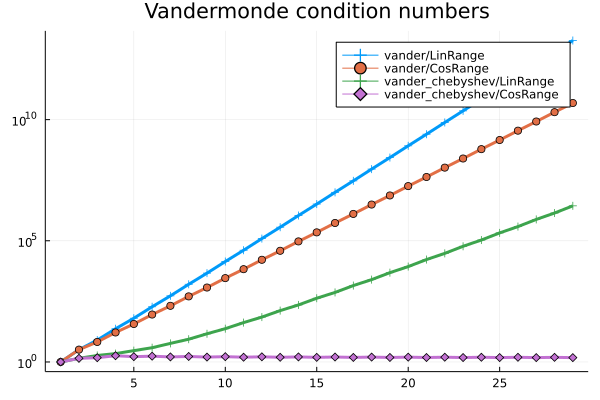

In [40]:
plot(title="Vandermonde condition numbers")
plot_cond(vander, LinRange)
plot_cond(vander, CosRange)
plot_cond(vander_chebyshev, LinRange)
plot_cond(vander_chebyshev, CosRange)

# Derivation of Chebyshev polynomials (supplemental)

Chebyshev polynomials are defined for non-negative integar $n$ as $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, but it's not obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos \big( (n+1) y \big) = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos \big( (n-1) y \big) = \cos ny \cos y + \sin ny \sin y
\end{split}$$
Adding these together produces
$$ T_{n+1}(x) + T_{n-1}(x) = 2\cos ny \cos y = 2 x \cos ny = 2 x T_n(x) $$
which yields a convenient recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

# Lagrange interpolating polynomials

Find the unique polynomial that is 0 at all but one `source` point.

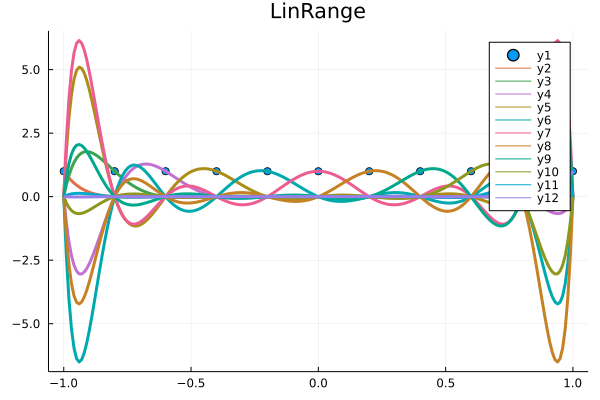

In [41]:
source = LinRange(-1, 1, 11)
target = LinRange(-1, 1, 200)
scatter(source, one.(source), title="LinRange")
plot!(target, interpolate(source, target))

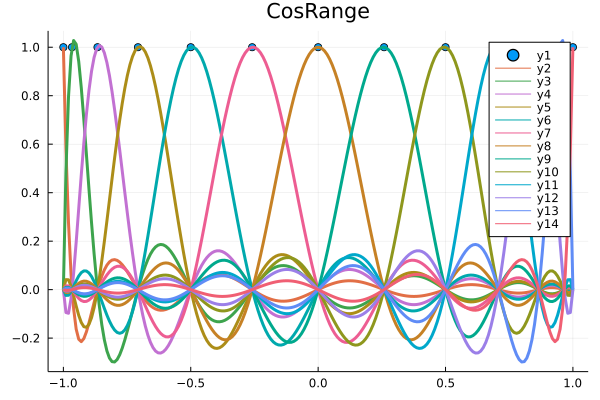

In [42]:
source = CosRange(-1, 1, 13)
target = LinRange(-1, 1, 200)
scatter(source, one.(source), title="CosRange")
plot!(target, interpolate(source, target))